<a href="https://colab.research.google.com/github/Hashnroll/pix2pix/blob/master/HW_pix2pix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Pix2Pix Google Maps

In [ ]:
!wget https://people.eecs.berkeley.edu/~tinghuiz/projects/pix2pix/datasets/maps.tar.gz

maps.tar.gz         100%[===================>] 238.65M  42.2MB/s    in 6.2s    

2020-06-22 13:59:21 (38.7 MB/s) - ‘maps.tar.gz’ saved [250242400/250242400]



In [ ]:
!tar -xvzf maps.tar.gz

In [ ]:
!rm maps.tar.gz

In [ ]:
from PIL import Image
import h5py
import os
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import random
%matplotlib inline

import torch
from torch import nn
from torch.utils import data
from torchvision import transforms

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


### Dataset, dataloader

In [ ]:
transform = transforms.Compose([transforms.Resize((256,256)),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])
train_images = list()
for file_name in tqdm(sorted(os.listdir('maps/train'))):
  img = Image.open(os.path.join(f'maps/train/{file_name}'))
  input_image = img.crop((0, 0, img.width // 2, img.height))
  target_image = img.crop((img.width // 2, 0, img.width, img.height))
  train_images.append([transform(input_image), transform(target_image)])

In [6]:
transform = transforms.Compose([transforms.Resize((256,256)),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])
val_images = list()
for file_name in tqdm(sorted(os.listdir('maps/val'))):
  img = Image.open(os.path.join(f'maps/val/{file_name}'))
  input_image = img.crop((0, 0, img.width // 2, img.height))
  target_image = img.crop((img.width // 2, 0, img.width, img.height))
  val_images.append([transform(input_image), transform(target_image)])

In [7]:
class ImageDataset(data.Dataset):
    def __init__(self, images, map_to_satel=True):
        super().__init__()
        self.images = images
        self.map_to_satel = map_to_satel
        
    def __getitem__(self, index):
      satel_image, map_image = self.images[index]
      if self.map_to_satel:
        return map_image, satel_image
      else:
        return satel_image, map_image

    def __len__(self):
        return len(self.images)

In [8]:
train_dataset = ImageDataset(train_images, map_to_satel=False)
train_loader = data.DataLoader(dataset=train_dataset, batch_size=1, shuffle=True, num_workers=4, pin_memory=True)

val_dataset = ImageDataset(val_images, map_to_satel=False)
val_loader = data.DataLoader(dataset=val_dataset, batch_size=1, shuffle=False, num_workers=1)

### Дискриминатор

In [12]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv0 = nn.Sequential(
            nn.Conv2d(6, 64, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU()
        )

        self.conv1 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU()
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU()
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=2, stride=1, padding=1),
            nn.LeakyReLU()
        )

        self.conv4 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=2, stride=1, padding=1),
            nn.LeakyReLU()
        )

        self.conv5 = nn.Conv2d(512, 1, kernel_size=1)
        

    def forward(self, x, label):
        x = torch.cat([x, label], dim=1)
        x = self.conv0(x)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        out = torch.nn.Sigmoid()(x)
        return out

### Генератор

In [11]:
class Generator(nn.Module):
  def __init__(self):
    super().__init__()

    # encoder (downsampling)
    self.enc_conv0 = nn.Sequential(
        nn.Conv2d(3, 64, kernel_size=3, padding=1),
        nn.BatchNorm2d(64),
        nn.LeakyReLU()
    )
    self.enc_conv1 = nn.Sequential(
        nn.Conv2d(64, 64, kernel_size=2, stride=2, padding=1),
        nn.Conv2d(64, 128, kernel_size=2, stride=1, padding=1),
        nn.BatchNorm2d(128),
        nn.LeakyReLU()
    )
    self.enc_conv2 = nn.Sequential(
        nn.Conv2d(128, 128, kernel_size=2, stride=2, padding=1),
        nn.Conv2d(128, 256, kernel_size=2, stride=1, padding=1),
        nn.BatchNorm2d(256),
        nn.LeakyReLU()
    )
    self.enc_conv3 = nn.Sequential(
        nn.Conv2d(256,256, kernel_size=2, stride=2, padding=1),
        nn.Conv2d(256, 512, kernel_size=2, stride=1, padding=1),
        nn.BatchNorm2d(512),
        nn.LeakyReLU()
    )
    self.bottleneck = nn.Sequential(
        nn.Conv2d(512,512, kernel_size=2, stride=2, padding=1),
        nn.Conv2d(512, 1024, kernel_size=2, stride=1, padding=1),
        nn.BatchNorm2d(1024),
        nn.LeakyReLU(),
        nn.Conv2d(1024, 512, kernel_size=2, stride=1, padding=1),
        nn.BatchNorm2d(512),
        nn.LeakyReLU()
    )

    # decoder
    self.upsample3 = nn.ConvTranspose2d(512, 512, kernel_size=2, stride=2, padding=3, output_padding=1)
    self.dec_conv3 = nn.Sequential(
        nn.Conv2d(1024, 512, kernel_size=2,  padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU()
    ) 
    self.upsample2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2, padding=3, output_padding=1)
    self.dec_conv2 = nn.Sequential(
        nn.Conv2d(512, 256, kernel_size=2, padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU()
    ) 
    self.upsample1 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2, padding=3)
    self.dec_conv1 = nn.Sequential(
        nn.Conv2d(256, 128, kernel_size=2, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU()
    ) 
    self.upsample0 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2, padding=3)
    self.dec_conv0 = nn.Sequential(
        nn.Conv2d(128, 64, kernel_size=3, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.Conv2d(64, 3, kernel_size=1)
    )

  def forward(self, x):
    e0 = self.enc_conv0(x)
    e1 = self.enc_conv1(e0)
    e2 = self.enc_conv2(e1)
    e3 = self.enc_conv3(e2)

    b = self.bottleneck(e3)
    # decoder
    d3 = self.upsample3(b)
    d3 = torch.cat((d3, e3), dim=1)
    d2 = self.dec_conv3(d3)

    d2 = self.upsample2(d2)
    d2 = torch.cat((d2, e2), dim=1)
    d1 = self.dec_conv2(d2)

    d1 = self.upsample1(d1)
    d1 = torch.cat((d1, e1), dim=1)
    d0 = self.dec_conv1(d1)

    d0 = self.upsample0(d0)
    d0 = torch.cat((d0, e0), dim=1)
    res = self.dec_conv0(d0) 
    return torch.nn.Tanh()(res)

In [ ]:
from torchsummary import summary
summary(Generator().to(device), (3,256,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
       BatchNorm2d-2         [-1, 64, 256, 256]             128
         LeakyReLU-3         [-1, 64, 256, 256]               0
            Conv2d-4         [-1, 64, 129, 129]          16,448
            Conv2d-5        [-1, 128, 130, 130]          32,896
       BatchNorm2d-6        [-1, 128, 130, 130]             256
         LeakyReLU-7        [-1, 128, 130, 130]               0
            Conv2d-8          [-1, 128, 66, 66]          65,664
            Conv2d-9          [-1, 256, 67, 67]         131,328
      BatchNorm2d-10          [-1, 256, 67, 67]             512
        LeakyReLU-11          [-1, 256, 67, 67]               0
           Conv2d-12          [-1, 256, 34, 34]         262,400
           Conv2d-13          [-1, 512, 35, 35]         524,800
      BatchNorm2d-14          [-1, 512,

### Функция обучения

In [13]:
def train(G, D, G_optimizer, D_optimizer, epoch_losses, num_epochs, val_step=100):
  G.train()
  D.train()

  out = Output()

  for epoch in tqdm(range(1, num_epochs + 1), desc='Эпоха'):
      D_loss_running, G_loss_running = 0.0, 0.0
      fig = None

      for i, (input_image, target_image) in enumerate(tqdm(train_loader, desc='Изображений обработано')):
          input_image = input_image.to(device)
          target = target_image.to(device)

          # Train discriminator with real data
          D_real_decision = D(input_image, target).squeeze()
          real_ = torch.ones(D_real_decision.size()).to(device)
          D_real_loss = BCE_loss(D_real_decision, real_)

          # Train discriminator with fake data
          gen_image = G(input_image)
          D_fake_decision = D(input_image, gen_image).squeeze()
          fake_ = torch.zeros(D_fake_decision.size()).to(device)
          D_fake_loss = BCE_loss(D_fake_decision, fake_)

          # Back propagation
          D_loss = (D_real_loss + D_fake_loss) * 0.5
          D_optimizer.zero_grad()
          D_loss.backward()
          D_optimizer.step()

          # Train generator
          gen_image = G(input_image)
          D_fake_decision = D(input_image, gen_image).squeeze()
          G_fake_loss = BCE_loss(D_fake_decision, real_)

          # L1 loss
          l1_loss_value = 100 * L1_loss(gen_image, target)

          # Back propagation
          G_loss = G_fake_loss + l1_loss_value
          G_optimizer.zero_grad()
          G_loss.backward()
          G_optimizer.step()

          # loss values
          D_loss_running += D_loss.item()
          G_loss_running += G_loss.item()

          if (i + 1) % val_step == 0:
            G.eval()
            val_image, val_target = val_dataset[random.randint(0, len(val_dataset)-1)]
            with torch.no_grad():
              gen_image = G(val_image.unsqueeze(0).to(device))

            gen_image = gen_image.detach().cpu()

            # print input, generated and true images
            with out:
              clear_output()
            out = Output()
            display(out)
            with out:
              plot_val(val_image, gen_image, val_target)

            G.train()

      D_loss_epoch = D_loss_running / len(train_loader)
      G_loss_epoch = G_loss_running / len(train_loader)
      print(f"Эпоха {epoch}/{num_epochs}: Disc loss={D_loss_epoch:.4f}, Gen loss={G_loss_epoch:.4f}")


      # avg loss values for plot
      epoch_losses['Disc'].append(D_loss_running / len(train_loader))
      epoch_losses['Gen'].append(G_loss_running / len(train_loader))

In [14]:
from ipywidgets import Output
from IPython.display import clear_output
import numpy as np

In [15]:
def unnorm_img(img):
  img = (((img[0] - img[0].min()) * 255) / (img[0].max() - img[0].min())).numpy().transpose(1, 2, 0).astype(np.uint8)
  return img

def plot_val(val_image, gen_image, val_target):
  fig, axs = plt.subplots(1, 3)
  fig.set_figheight(10)
  fig.set_figwidth(10)

  val_image = unnorm_img(val_image.unsqueeze(0))
  gen_image = unnorm_img(gen_image)
  val_target = unnorm_img(val_target.unsqueeze(0))
  axs[0].imshow(val_image, cmap=None)
  axs[0].set_title('Input', fontsize=16)
  axs[0].axis('off')
  axs[1].imshow(gen_image, cmap=None)
  axs[1].set_title('Generated', fontsize=16)
  axs[1].axis('off')
  axs[2].imshow(val_target, cmap=None)
  axs[2].set_title('Target', fontsize=16)
  axs[2].axis('off')
  fig.tight_layout()
  plt.show()

### Обучение

In [16]:
BCE_loss = torch.nn.BCELoss()
L1_loss = torch.nn.L1Loss()

G = Generator().to(device)
D = Discriminator().to(device)

G_optimizer = torch.optim.Adam(G.parameters(), lr=2e-4, betas=(0.5, 0.999))
D_optimizer = torch.optim.Adam(D.parameters(), lr=2e-4, betas=(0.5, 0.999))

num_epochs = 50
epoch_losses = {'Disc':[], 'Gen':[]}

In [ ]:
train(G, D, G_optimizer, D_optimizer, epoch_losses, num_epochs, val_step=200)

Output()

Output()

Output()

Output()

Output()


Эпоха 1/50: Disc loss=0.5654, Gen loss=14.7428


Output()

Output()

Output()

Output()

Output()


Эпоха 2/50: Disc loss=0.5670, Gen loss=10.7174


Output()

Output()

Output()

Output()

Output()


Эпоха 3/50: Disc loss=0.5548, Gen loss=10.0048


Output()

Output()

Output()

Output()

Output()


Эпоха 4/50: Disc loss=0.5571, Gen loss=9.5356


Output()

Output()

Output()

Output()

Output()


Эпоха 5/50: Disc loss=0.5365, Gen loss=9.3935


Output()

Output()

Output()

Output()

Output()


Эпоха 6/50: Disc loss=0.5447, Gen loss=9.2145


Output()

Output()

Output()

Output()

Output()


Эпоха 7/50: Disc loss=0.5271, Gen loss=9.0417


Output()

Output()

Output()

Output()

Output()


Эпоха 8/50: Disc loss=0.5571, Gen loss=8.8685


Output()

Output()

Output()

Output()

Output()


Эпоха 9/50: Disc loss=0.5492, Gen loss=8.5336


Output()

Output()

Output()

Output()

Output()


Эпоха 10/50: Disc loss=0.5327, Gen loss=8.5666


Output()

Output()

Output()

Output()

Output()


Эпоха 11/50: Disc loss=0.5376, Gen loss=8.5933


Output()

Output()

Output()

Output()

Output()


Эпоха 12/50: Disc loss=0.5222, Gen loss=8.3773


Output()

Output()

Output()

Output()

Output()


Эпоха 13/50: Disc loss=0.5574, Gen loss=7.9958


Output()

Output()

Output()

Output()

Output()


Эпоха 14/50: Disc loss=0.5243, Gen loss=8.2609


Output()

Output()

Output()

Output()

Output()


Эпоха 15/50: Disc loss=0.5061, Gen loss=8.5379


Output()

Output()

Output()

Output()

Output()


Эпоха 16/50: Disc loss=0.5173, Gen loss=8.2505


Output()

Output()

Output()

Output()

Output()


Эпоха 17/50: Disc loss=0.5202, Gen loss=7.9844


Output()

Output()

Output()

Output()

Output()


Эпоха 18/50: Disc loss=0.5145, Gen loss=8.0272


Output()

Output()

Output()

Output()

Output()


Эпоха 19/50: Disc loss=0.5123, Gen loss=7.8790


Output()

Output()

Output()

Output()

Output()


Эпоха 20/50: Disc loss=0.4924, Gen loss=8.1230


Output()

Output()

Output()

Output()

Output()


Эпоха 21/50: Disc loss=0.5074, Gen loss=7.7039


Output()

Output()

Output()

Output()

Output()


Эпоха 22/50: Disc loss=0.5141, Gen loss=7.6960


Output()

Output()

Output()

Output()

Output()


Эпоха 23/50: Disc loss=0.4885, Gen loss=7.7048


Output()

Output()

Output()

Output()

Output()


Эпоха 24/50: Disc loss=0.4946, Gen loss=7.8226


Output()

Output()

Output()

Output()

Output()


Эпоха 25/50: Disc loss=0.4840, Gen loss=7.6112


Output()

Output()

Output()

Output()

Output()


Эпоха 26/50: Disc loss=0.5008, Gen loss=7.3722


Output()

Output()

Output()

Output()

Output()


Эпоха 27/50: Disc loss=0.5188, Gen loss=7.2734


Output()

Output()

Output()

Output()

Output()


Эпоха 28/50: Disc loss=0.4957, Gen loss=7.2808


Output()

Output()

Output()

Output()

Output()


Эпоха 29/50: Disc loss=0.4741, Gen loss=7.3285


Output()

Output()

Output()

Output()

Output()


Эпоха 30/50: Disc loss=0.4630, Gen loss=7.4216


Output()

Output()

Output()

Output()

Output()


Эпоха 31/50: Disc loss=0.4598, Gen loss=7.4062


Output()

Output()

Output()

Output()

Output()


Эпоха 32/50: Disc loss=0.4607, Gen loss=7.1440


Output()

Output()

Output()

Output()

Output()


Эпоха 33/50: Disc loss=0.4623, Gen loss=7.2502


Output()

Output()

Output()

Output()

Output()


Эпоха 34/50: Disc loss=0.4419, Gen loss=7.4475


Output()

Output()

Output()

Output()

Output()


Эпоха 35/50: Disc loss=0.4705, Gen loss=6.9531


Output()

Output()

Output()

Output()

Output()


Эпоха 36/50: Disc loss=0.4585, Gen loss=7.1158


Output()

Output()

Output()

Output()

Output()


Эпоха 37/50: Disc loss=0.4524, Gen loss=7.0202


Output()

Output()

Output()

Output()

Output()


Эпоха 38/50: Disc loss=0.4921, Gen loss=6.9551


Output()

Output()

Output()

Output()

Output()


Эпоха 39/50: Disc loss=0.4464, Gen loss=7.1210


Output()

Output()

Output()

Output()

Output()


Эпоха 40/50: Disc loss=0.4474, Gen loss=6.9335


Output()

Output()

Output()

Output()

Output()


Эпоха 41/50: Disc loss=0.4561, Gen loss=6.7046


Output()

Output()

Output()

Output()

Output()


Эпоха 42/50: Disc loss=0.4582, Gen loss=6.7609


Output()

Output()

Output()

Output()

Output()


Эпоха 43/50: Disc loss=0.4507, Gen loss=6.9802


Output()

Output()

Output()

Output()

Output()


Эпоха 44/50: Disc loss=0.4835, Gen loss=6.6755


Output()

Output()

Output()

Output()

Output()


Эпоха 45/50: Disc loss=0.4743, Gen loss=6.5449


Output()

Output()

Output()

Output()

Output()


Эпоха 46/50: Disc loss=0.4323, Gen loss=7.2704


Output()

Output()

Output()

Output()

Output()


Эпоха 47/50: Disc loss=0.4384, Gen loss=6.6646


Output()

Output()

Output()

Output()

Output()


Эпоха 48/50: Disc loss=0.4363, Gen loss=6.7789


Output()

Output()

Output()

Output()

Output()


Эпоха 49/50: Disc loss=0.4403, Gen loss=6.6282


Output()

Output()

Output()

Output()

Output()


Эпоха 50/50: Disc loss=0.4348, Gen loss=6.7772



In [ ]:
torch.save(G.state_dict(), 'gen_50epochs.pth')
torch.save(D.state_dict(), 'disc_50epochs.pth')

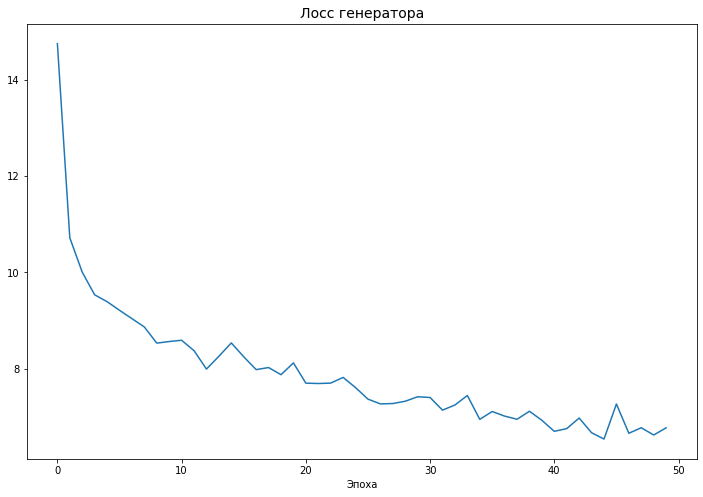

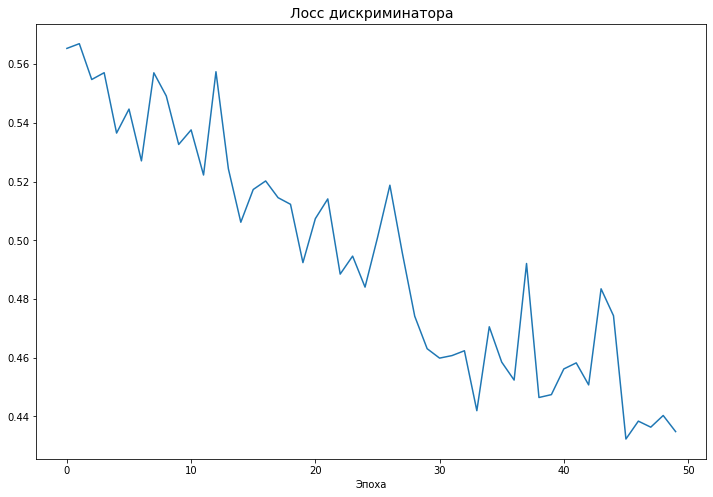

In [ ]:
plt.figure(figsize=(12, 8))
plt.title('Лосс генератора', fontsize=14)
plt.xlabel('Эпоха')
plt.plot(epoch_losses['Gen'])
plt.show()

plt.figure(figsize=(12, 8))
plt.title('Лосс дискриминатора', fontsize=14)
plt.xlabel('Эпоха')
plt.plot(epoch_losses['Disc'])
plt.show()

Дообучим еще 50 эпох

In [ ]:
G_optimizer = torch.optim.Adam(G.parameters(), lr=1e-4, betas=(0.5, 0.999))
D_optimizer = torch.optim.Adam(D.parameters(), lr=1e-4, betas=(0.5, 0.999))

num_epochs = 50
train(G, D, G_optimizer, D_optimizer, epoch_losses, num_epochs, val_step=500)

Output()

Output()


Эпоха 1/50: Disc loss=0.4000, Gen loss=6.6517


Output()

Output()


Эпоха 2/50: Disc loss=0.4101, Gen loss=6.4801


Output()

Output()


Эпоха 3/50: Disc loss=0.4056, Gen loss=6.4647


Output()

Output()


Эпоха 4/50: Disc loss=0.4034, Gen loss=6.5249


Output()

Output()


Эпоха 5/50: Disc loss=0.4024, Gen loss=6.4564


Output()

Output()


Эпоха 6/50: Disc loss=0.3984, Gen loss=6.5437


Output()

Output()


Эпоха 7/50: Disc loss=0.4097, Gen loss=6.3719


Output()

Output()


Эпоха 8/50: Disc loss=0.4049, Gen loss=6.4059


Output()

Output()


Эпоха 9/50: Disc loss=0.4019, Gen loss=6.4493


Output()

Output()


Эпоха 10/50: Disc loss=0.4094, Gen loss=6.3535


Output()

Output()


Эпоха 11/50: Disc loss=0.4004, Gen loss=6.3896


Output()

Output()


Эпоха 12/50: Disc loss=0.4117, Gen loss=6.2949


Output()

Output()


Эпоха 13/50: Disc loss=0.4066, Gen loss=6.3331


Output()

Output()


Эпоха 14/50: Disc loss=0.4013, Gen loss=6.3764


Output()

Output()


Эпоха 15/50: Disc loss=0.4010, Gen loss=6.3351


Output()

Output()


Эпоха 16/50: Disc loss=0.4056, Gen loss=6.3391


Output()

Output()


Эпоха 17/50: Disc loss=0.4043, Gen loss=6.3382


Output()

Output()


Эпоха 18/50: Disc loss=0.4081, Gen loss=6.2913


Output()

Output()


Эпоха 19/50: Disc loss=0.4038, Gen loss=6.2873


Output()

Output()


Эпоха 20/50: Disc loss=0.4103, Gen loss=6.2278


Output()

Output()


Эпоха 21/50: Disc loss=0.4800, Gen loss=5.7801


Output()

Output()


Эпоха 22/50: Disc loss=0.4050, Gen loss=6.2455


Output()

Output()


Эпоха 23/50: Disc loss=0.4023, Gen loss=6.3172


Output()

Output()


Эпоха 24/50: Disc loss=0.4031, Gen loss=6.3184


Output()

Output()


Эпоха 25/50: Disc loss=0.4077, Gen loss=6.2411


Output()

Output()


Эпоха 26/50: Disc loss=0.4011, Gen loss=6.2784


Output()

Output()


Эпоха 27/50: Disc loss=0.4095, Gen loss=6.2241


Output()

Output()


Эпоха 28/50: Disc loss=0.4095, Gen loss=6.1796


Output()

Output()


Эпоха 29/50: Disc loss=0.4070, Gen loss=6.2114


Output()

Output()


Эпоха 30/50: Disc loss=0.4013, Gen loss=6.2690


Output()

Output()


Эпоха 31/50: Disc loss=0.4075, Gen loss=6.1902


Output()

Output()


Эпоха 32/50: Disc loss=0.4062, Gen loss=6.1921


Output()

Output()


Эпоха 33/50: Disc loss=0.4047, Gen loss=6.2105


Output()

Output()


Эпоха 34/50: Disc loss=0.4085, Gen loss=6.1532


Output()

Output()


Эпоха 35/50: Disc loss=0.4075, Gen loss=6.2226


Output()

Output()


Эпоха 36/50: Disc loss=0.4041, Gen loss=6.1929


Output()

Output()


Эпоха 37/50: Disc loss=0.4094, Gen loss=6.1393


Output()

Output()


Эпоха 38/50: Disc loss=0.4064, Gen loss=6.1858


Output()

Output()


Эпоха 39/50: Disc loss=0.4118, Gen loss=6.1253


Output()

Output()


Эпоха 40/50: Disc loss=0.4098, Gen loss=6.1092


Output()

Output()


Эпоха 41/50: Disc loss=0.4080, Gen loss=6.1736


Output()

Output()


Эпоха 42/50: Disc loss=0.4196, Gen loss=6.0501


Output()

Output()


Эпоха 43/50: Disc loss=0.4085, Gen loss=6.1166


Output()

Output()


Эпоха 44/50: Disc loss=0.4097, Gen loss=6.1054


Output()

Output()


Эпоха 45/50: Disc loss=0.4016, Gen loss=6.2750


Output()

Output()


Эпоха 46/50: Disc loss=0.4177, Gen loss=6.0613


Output()

Output()


Эпоха 47/50: Disc loss=0.4102, Gen loss=6.0835


Output()

Output()


Эпоха 48/50: Disc loss=0.4158, Gen loss=6.0754


Output()

Output()


Эпоха 49/50: Disc loss=0.4097, Gen loss=6.0815


Output()

Output()


Эпоха 50/50: Disc loss=0.4177, Gen loss=6.0405



In [ ]:
torch.save(G.state_dict(), 'gen_100epochs.pth')
torch.save(D.state_dict(), 'disc_100epochs.pth')

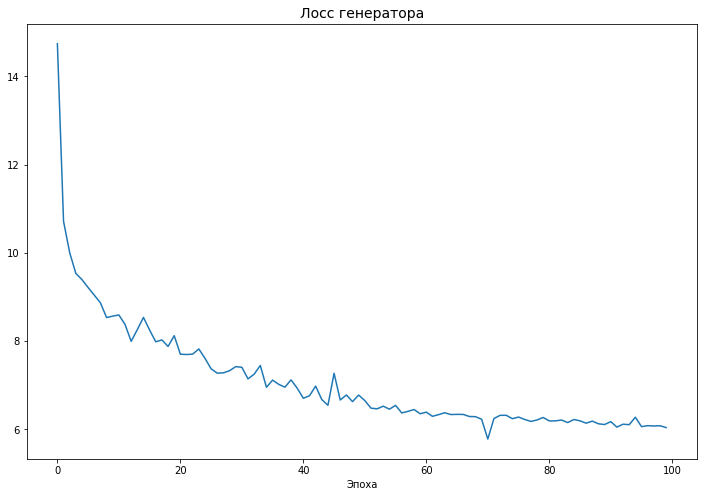

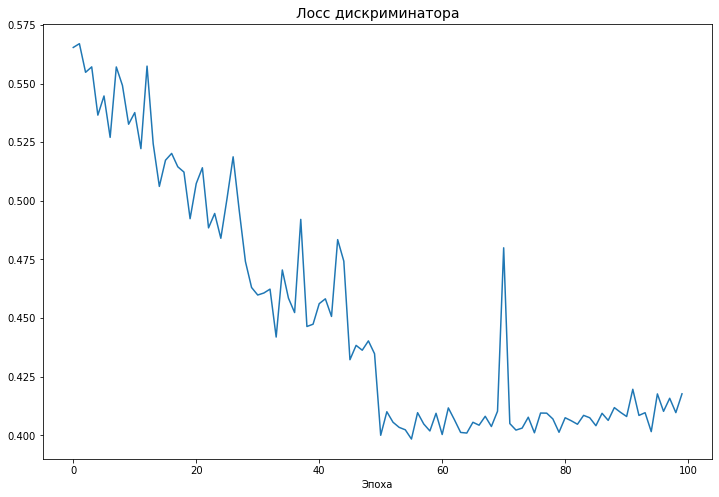

In [ ]:
plt.figure(figsize=(12, 8))
plt.title('Лосс генератора', fontsize=14)
plt.xlabel('Эпоха')
plt.plot(epoch_losses['Gen'])
plt.show()

plt.figure(figsize=(12, 8))
plt.title('Лосс дискриминатора', fontsize=14)
plt.xlabel('Эпоха')
plt.plot(epoch_losses['Disc'])
plt.show()

Дообучим еще 100 эпох

In [ ]:
G_optimizer = torch.optim.Adam(G.parameters(), lr=1e-4, betas=(0.5, 0.999))
D_optimizer = torch.optim.Adam(D.parameters(), lr=1e-4, betas=(0.5, 0.999))

num_epochs = 100
train(G, D, G_optimizer, D_optimizer, epoch_losses, num_epochs, val_step=500)

Output()

Output()


Эпоха 1/100: Disc loss=0.4161, Gen loss=6.0473


Output()

Output()


Эпоха 2/100: Disc loss=0.4154, Gen loss=6.0621


Output()

Output()


Эпоха 3/100: Disc loss=0.4063, Gen loss=6.1566


Output()

Output()


Эпоха 4/100: Disc loss=0.4131, Gen loss=6.0567


Output()

Output()


Эпоха 5/100: Disc loss=0.4179, Gen loss=6.0360


Output()

Output()


Эпоха 6/100: Disc loss=0.4212, Gen loss=5.9843


Output()

Output()


Эпоха 7/100: Disc loss=0.4458, Gen loss=5.8659


Output()

Output()


Эпоха 8/100: Disc loss=0.4086, Gen loss=6.0995


Output()

Output()


Эпоха 9/100: Disc loss=0.4090, Gen loss=6.0955


Output()

Output()


Эпоха 10/100: Disc loss=0.4242, Gen loss=5.9453


Output()

Output()


Эпоха 11/100: Disc loss=0.4083, Gen loss=6.1033


Output()

Output()


Эпоха 12/100: Disc loss=0.4215, Gen loss=5.9811


Output()

Output()


Эпоха 13/100: Disc loss=0.4247, Gen loss=5.9364


Output()

Output()


Эпоха 14/100: Disc loss=0.4234, Gen loss=5.9292


Output()

Output()


Эпоха 15/100: Disc loss=0.4317, Gen loss=5.8881


Output()

Output()


Эпоха 16/100: Disc loss=0.4153, Gen loss=6.0024


Output()

Output()


Эпоха 17/100: Disc loss=0.4239, Gen loss=5.9451


Output()

Output()


Эпоха 18/100: Disc loss=0.4249, Gen loss=5.9026


Output()

Output()


Эпоха 19/100: Disc loss=0.4166, Gen loss=6.0242


Output()

Output()


Эпоха 20/100: Disc loss=0.4266, Gen loss=5.9012


Output()

Output()


Эпоха 21/100: Disc loss=0.4231, Gen loss=5.9206


Output()

Output()


Эпоха 22/100: Disc loss=0.4194, Gen loss=5.9803


Output()

Output()


Эпоха 23/100: Disc loss=0.4284, Gen loss=5.9445


Output()

Output()


Эпоха 24/100: Disc loss=0.4243, Gen loss=5.8809


Output()

Output()


Эпоха 25/100: Disc loss=0.4231, Gen loss=5.9180


Output()

Output()


Эпоха 26/100: Disc loss=0.4147, Gen loss=5.9894


Output()

Output()


Эпоха 27/100: Disc loss=0.4275, Gen loss=5.8575


Output()

Output()


Эпоха 28/100: Disc loss=0.4285, Gen loss=5.8432


Output()

Output()


Эпоха 29/100: Disc loss=0.4213, Gen loss=5.9126


Output()

Output()


Эпоха 30/100: Disc loss=0.4283, Gen loss=5.8740


Output()

Output()


Эпоха 31/100: Disc loss=0.4227, Gen loss=5.8878


Output()

Output()


Эпоха 32/100: Disc loss=0.4291, Gen loss=5.8407


Output()

Output()


Эпоха 33/100: Disc loss=0.4297, Gen loss=5.8447


Output()

Output()


Эпоха 34/100: Disc loss=0.4269, Gen loss=5.8287


Output()

Output()


Эпоха 35/100: Disc loss=0.4290, Gen loss=5.7963


Output()

Output()


Эпоха 36/100: Disc loss=0.4274, Gen loss=5.8399


Output()

Output()


Эпоха 37/100: Disc loss=0.4309, Gen loss=5.7976


Output()

Output()


Эпоха 38/100: Disc loss=0.4373, Gen loss=5.7494


Output()

Output()


Эпоха 39/100: Disc loss=0.4225, Gen loss=5.8936


Output()

Output()


Эпоха 40/100: Disc loss=0.4396, Gen loss=5.7178


Output()

Output()


Эпоха 41/100: Disc loss=0.4331, Gen loss=5.7619


Output()

Output()


Эпоха 42/100: Disc loss=0.4322, Gen loss=5.7897


Output()

Output()


Эпоха 43/100: Disc loss=0.4350, Gen loss=5.7447


Output()

Output()


Эпоха 44/100: Disc loss=0.4303, Gen loss=5.7956


Output()

Output()


Эпоха 45/100: Disc loss=0.4336, Gen loss=5.7516


Output()

Output()


Эпоха 46/100: Disc loss=0.4319, Gen loss=5.7850


Output()

Output()


Эпоха 47/100: Disc loss=0.4359, Gen loss=5.7114


Output()

Output()


Эпоха 48/100: Disc loss=0.4326, Gen loss=5.7630


Output()

Output()


Эпоха 49/100: Disc loss=0.4350, Gen loss=5.7429


Output()

Output()


Эпоха 50/100: Disc loss=0.4358, Gen loss=5.7296


Output()

Output()


Эпоха 51/100: Disc loss=0.4361, Gen loss=5.7147


Output()

Output()


Эпоха 52/100: Disc loss=0.4361, Gen loss=5.7211


Output()

Output()


Эпоха 53/100: Disc loss=0.4341, Gen loss=5.7334


Output()

Output()


Эпоха 54/100: Disc loss=0.4345, Gen loss=5.7159


Output()

Output()


Эпоха 55/100: Disc loss=0.4325, Gen loss=5.7563


Output()

Output()


Эпоха 56/100: Disc loss=0.4353, Gen loss=5.7163


Output()

Output()


Эпоха 57/100: Disc loss=0.4368, Gen loss=5.7117


Output()

Output()


Эпоха 58/100: Disc loss=0.4416, Gen loss=5.6594


Output()

Output()


Эпоха 59/100: Disc loss=0.4382, Gen loss=5.6734


Output()

Output()


Эпоха 60/100: Disc loss=0.4396, Gen loss=5.6538


Output()

Output()


Эпоха 61/100: Disc loss=0.4390, Gen loss=5.6571


Output()

Output()


Эпоха 62/100: Disc loss=0.4365, Gen loss=5.7099


Output()

Output()


Эпоха 63/100: Disc loss=0.4413, Gen loss=5.6425


Output()

Output()


Эпоха 64/100: Disc loss=0.4337, Gen loss=5.7013


Output()

Output()


Эпоха 65/100: Disc loss=0.4434, Gen loss=5.6222


Output()

Output()


Эпоха 66/100: Disc loss=0.4436, Gen loss=5.6279


Output()

Output()


Эпоха 67/100: Disc loss=0.4322, Gen loss=5.7411


Output()

Output()


Эпоха 68/100: Disc loss=0.4392, Gen loss=5.6428


Output()

Output()


Эпоха 69/100: Disc loss=0.4433, Gen loss=5.6256


Output()

Output()


Эпоха 70/100: Disc loss=0.4811, Gen loss=5.4202


Output()

Output()


Эпоха 71/100: Disc loss=0.4425, Gen loss=5.6177


Output()

Output()


Эпоха 72/100: Disc loss=0.4452, Gen loss=5.5714


Output()

Output()


Эпоха 73/100: Disc loss=0.4477, Gen loss=5.5770


Output()

Output()


Эпоха 74/100: Disc loss=0.4451, Gen loss=5.5615


Output()

Output()


Эпоха 75/100: Disc loss=0.4419, Gen loss=5.6309


Output()

Output()


Эпоха 76/100: Disc loss=0.4427, Gen loss=5.5956


Output()

Output()


Эпоха 77/100: Disc loss=0.4480, Gen loss=5.5694


Output()

Output()


Эпоха 78/100: Disc loss=0.4409, Gen loss=5.6314


Output()

Output()


Эпоха 79/100: Disc loss=0.4446, Gen loss=5.5601


Output()

Output()


Эпоха 80/100: Disc loss=0.4457, Gen loss=5.5439


Output()

Output()


Эпоха 81/100: Disc loss=0.4503, Gen loss=5.5178


Output()

Output()


Эпоха 82/100: Disc loss=0.4497, Gen loss=5.5201


Output()

Output()


Эпоха 83/100: Disc loss=0.4497, Gen loss=5.5436


Output()

Output()


Эпоха 84/100: Disc loss=0.4447, Gen loss=5.5523


Output()

Output()


Эпоха 85/100: Disc loss=0.4500, Gen loss=5.5231


Output()

Output()


Эпоха 86/100: Disc loss=0.4440, Gen loss=5.5621


Output()

Output()


Эпоха 87/100: Disc loss=0.4481, Gen loss=5.5511


Output()

Output()


Эпоха 88/100: Disc loss=0.4507, Gen loss=5.5202


Output()

Output()


Эпоха 89/100: Disc loss=0.4477, Gen loss=5.5402


Output()

Output()


Эпоха 90/100: Disc loss=0.4499, Gen loss=5.5049


Output()

Output()


Эпоха 91/100: Disc loss=0.4488, Gen loss=5.5001


Output()

Output()


Эпоха 92/100: Disc loss=0.4506, Gen loss=5.5001


Output()

Output()


Эпоха 93/100: Disc loss=0.4502, Gen loss=5.5097


Output()

Output()


Эпоха 94/100: Disc loss=0.4479, Gen loss=5.5226


Output()

Output()


Эпоха 95/100: Disc loss=0.4515, Gen loss=5.4982


Output()

Output()


Эпоха 96/100: Disc loss=0.4535, Gen loss=5.4748


Output()

Output()


Эпоха 97/100: Disc loss=0.4500, Gen loss=5.5064


Output()

Output()


Эпоха 98/100: Disc loss=0.4527, Gen loss=5.4799


Output()

Output()


Эпоха 99/100: Disc loss=0.4530, Gen loss=5.5153


Output()

Output()


Эпоха 100/100: Disc loss=0.4469, Gen loss=5.4953



In [ ]:
torch.save(G.state_dict(), 'gen_200epochs.pth')
torch.save(D.state_dict(), 'disc_200epochs.pth')

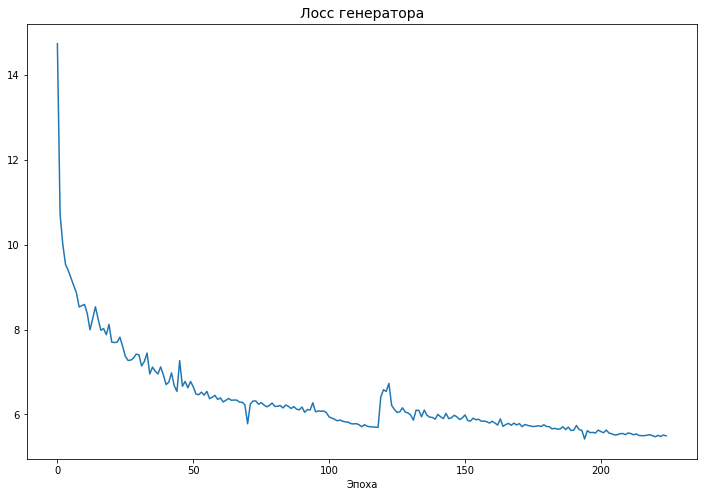

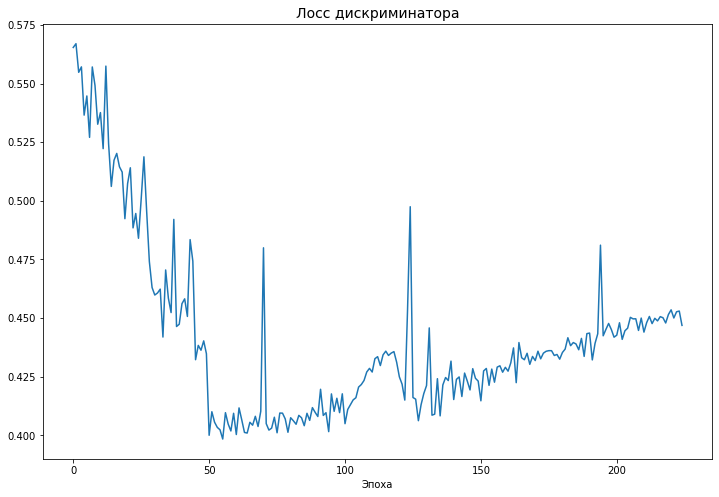

In [ ]:
plt.figure(figsize=(12, 8))
plt.title('Лосс генератора', fontsize=14)
plt.xlabel('Эпоха')
plt.plot(epoch_losses['Gen'])
plt.show()

plt.figure(figsize=(12, 8))
plt.title('Лосс дискриминатора', fontsize=14)
plt.xlabel('Эпоха')
plt.plot(epoch_losses['Disc'])
plt.show()

### Посмотрим на результат на нескольких изображениях из валидационной выборки

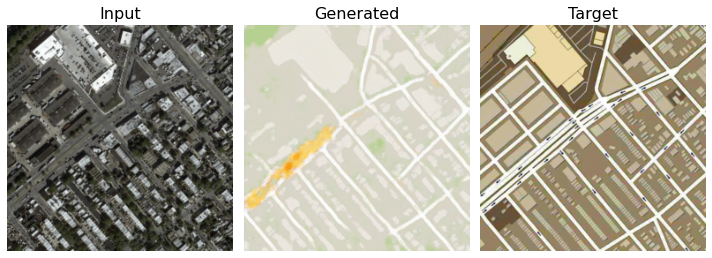

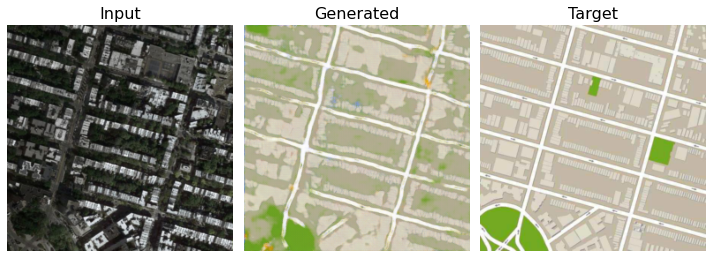

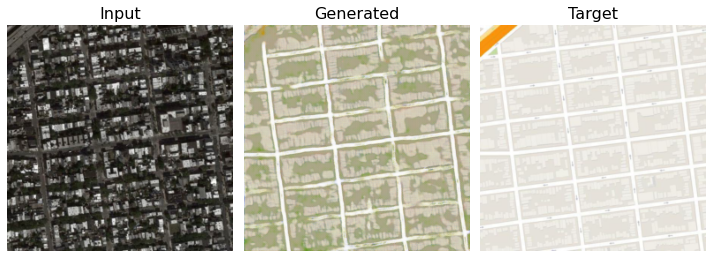

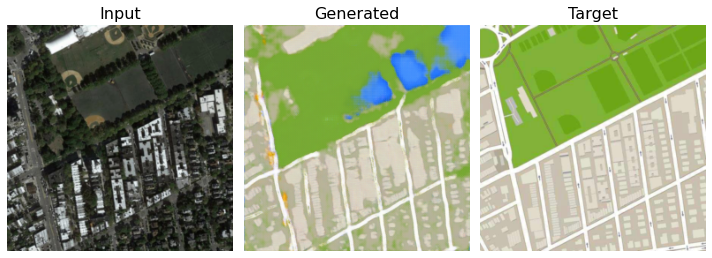

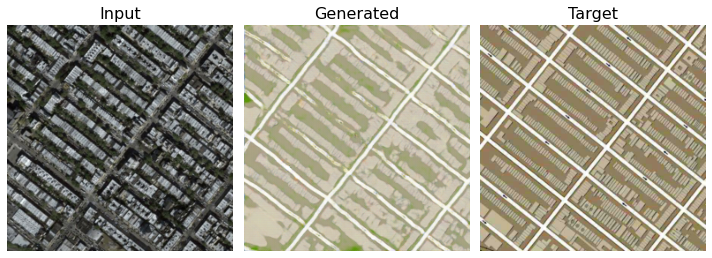

In [ ]:
G.eval()

for _ in range(5):
  val_image, val_target = val_dataset[random.randint(0, len(val_dataset)-1)]
  with torch.no_grad():
    gen_image = G(val_image.unsqueeze(0).to(device))

  gen_image = gen_image.detach().cpu()

  plot_val(val_image, gen_image, val_target)

Загрузим веса 100 эпох, и сравним с 200 эпохами

In [32]:
G.load_state_dict(torch.load('gen_100epochs.pth'))

<All keys matched successfully>

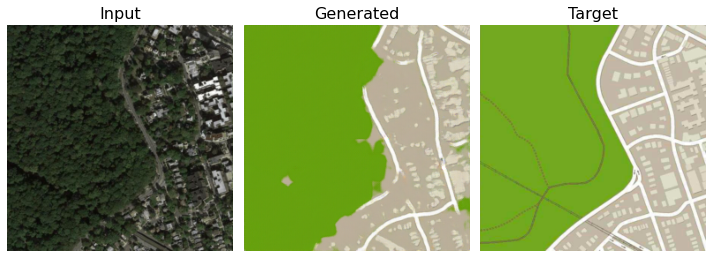

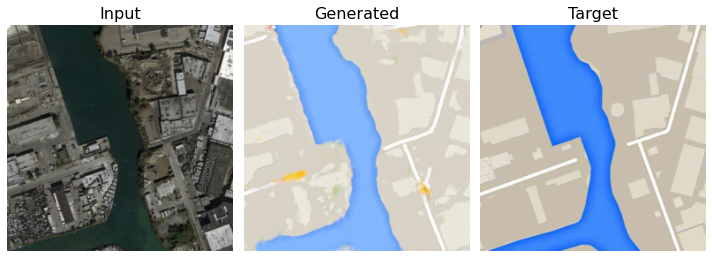

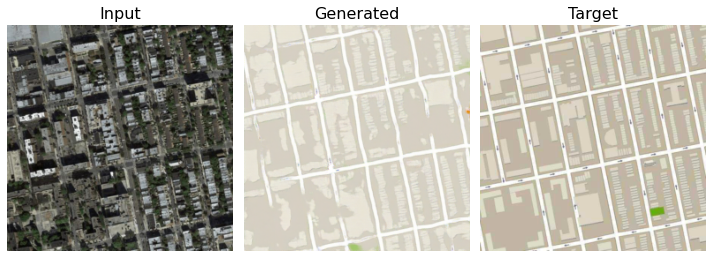

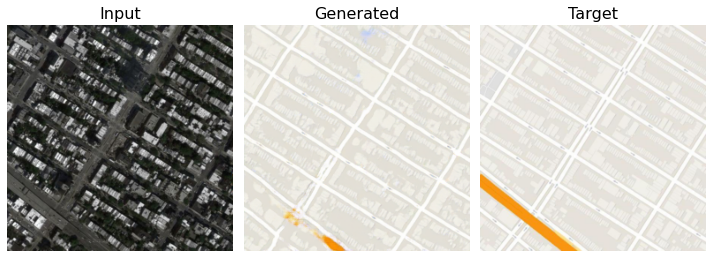

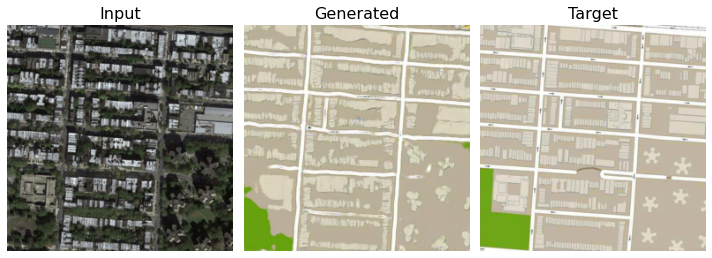

In [30]:
G.eval()

for _ in range(5):
  val_image, val_target = val_dataset[random.randint(0, len(val_dataset)-1)]
  with torch.no_grad():
    gen_image = G(val_image.unsqueeze(0).to(device))

  gen_image = gen_image.detach().cpu()

  plot_val(val_image, gen_image, val_target)

100 эпох выглядят лучше, чем 200. К тому же после 100 эпох лосс дискриминатора значительно вырос.